<a href="https://colab.research.google.com/github/seeedata/BADA/blob/main/0511%20Association%20Analysis%20Practice/Session%20Practice%20Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pymining

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import networkx as nx
from pymining import seqmining
import warnings
warnings.filterwarnings('ignore')

### 1. Basics

In [ ]:
#구글 드라이브에서 파일의 공유 가능한 링크
url="https://drive.google.com/file/d/12g-jiVuGb6yhaVZOLBoANctrb8b-pKpX/view?usp=sharing"
#파일 ID를 사용하여 다운로드 링크 생성
#url.split('/')[-2]: 파일 ID
path='https://drive.google.com/uc?id='+url.split('/')[-2]
print("▶ 공유파일 링크변환 경로명 : ", path)

data=pd.read_csv(path)

▶ 공유파일 링크변환 경로명 :  https://drive.google.com/uc?id=12g-jiVuGb6yhaVZOLBoANctrb8b-pKpX


##### 변수 설명

TransactionNo: unique identifier for every single transaction

Items: items purchased

DateTime: date and time stamp of the transactions

Daypart: part of the day when a transaction is made(morning, afternoon, evening, night)

DayType: classifies whether a transaction has been made in weekend or weekdays

In [ ]:
data.head()

,TransactionNo,Items,DateTime,Daypart,DayType
0,1,Bread,2016-10-30 09:58:11,Morning,Weekend
1,2,Scandinavian,2016-10-30 10:05:34,Morning,Weekend
2,2,Scandinavian,2016-10-30 10:05:34,Morning,Weekend
3,3,Hot chocolate,2016-10-30 10:07:57,Morning,Weekend
4,3,Jam,2016-10-30 10:07:57,Morning,Weekend


In [ ]:
data.shape

(20507, 5)

In [ ]:
data.info()
# dateTime의 dtype이 이상함. object라고 되어 있음.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20507 entries, 0 to 20506
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TransactionNo  20507 non-null  int64 
 1   Items          20507 non-null  object
 2   DateTime       20507 non-null  object
 3   Daypart        20507 non-null  object
 4   DayType        20507 non-null  object
dtypes: int64(1), object(4)
memory usage: 801.2+ KB


In [ ]:
data.isna().sum()

TransactionNo    0
Items            0
DateTime         0
Daypart          0
DayType          0
dtype: int64

In [ ]:
data['DateTime'] = pd.to_datetime(data['DateTime'])
data['Day']=data['DateTime'].dt.day_name()
data['Month_name']=data['DateTime'].dt.month_name()
data.head()

,TransactionNo,Items,DateTime,Daypart,DayType,Day,Month_name
0,1,Bread,2016-10-30 09:58:11,Morning,Weekend,Sunday,October
1,2,Scandinavian,2016-10-30 10:05:34,Morning,Weekend,Sunday,October
2,2,Scandinavian,2016-10-30 10:05:34,Morning,Weekend,Sunday,October
3,3,Hot chocolate,2016-10-30 10:07:57,Morning,Weekend,Sunday,October
4,3,Jam,2016-10-30 10:07:57,Morning,Weekend,Sunday,October


### 2. EDA

In [ ]:
# Unique data
data['Items'].nunique()

94

item이 94개라 너무 많으니, 상위 10개의 item을 대상으로 그래프를 그리자.


In [ ]:
#판매량이 높은 상위 10개의 item들의 리스트를 만들자
items10_list = list(data['Items'].value_counts().sort_values(ascending = False).head(10).index)
print(items10_list)

['Coffee', 'Bread', 'Tea', 'Cake', 'Pastry', 'Sandwich', 'Medialuna', 'Hot chocolate', 'Cookies', 'Brownie']


In [ ]:
#판매량이 높은 상위 10개의 item만 있는 데이터프레임을 추출하자
data_10 = data[data['Items'].isin(items10_list)]
data_10

,TransactionNo,Items,DateTime,Daypart,DayType,Day,Month_name
0,1,Bread,2016-10-30 09:58:11,Morning,Weekend,Sunday,October
3,3,Hot chocolate,2016-10-30 10:07:57,Morning,Weekend,Sunday,October
5,3,Cookies,2016-10-30 10:07:57,Morning,Weekend,Sunday,October
7,5,Coffee,2016-10-30 10:13:03,Morning,Weekend,Sunday,October
8,5,Pastry,2016-10-30 10:13:03,Morning,Weekend,Sunday,October
...,...,...,...,...,...,...,...
20497,9681,Tea,2017-09-04 14:30:09,Afternoon,Weekend,Monday,September
20502,9682,Coffee,2017-09-04 14:32:58,Afternoon,Weekend,Monday,September
20503,9682,Tea,2017-09-04 14:32:58,Afternoon,Weekend,Monday,September
20504,9683,Coffee,2017-09-04 14:57:06,Afternoon,Weekend,Monday,September


1. item별 판매량을 막대 그래프로 나타내보자

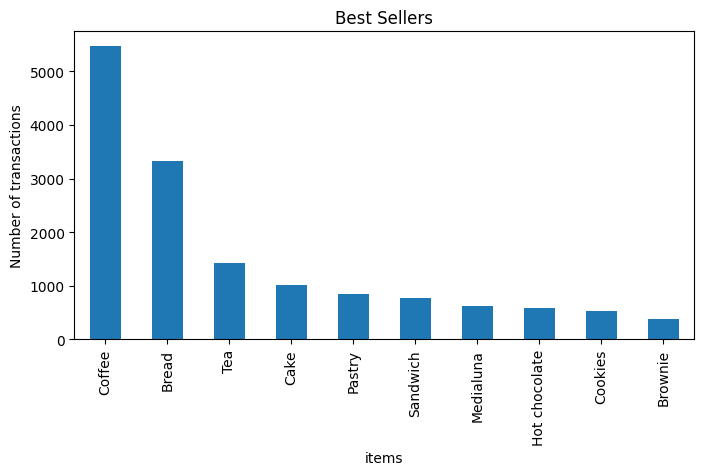

In [ ]:
plt.figure(figsize = (8, 4))

data_10['Items'].value_counts().sort_values(ascending = False).plot(kind = 'bar')

plt.title('Best Sellers')
plt.xlabel('items')
plt.ylabel('Number of transactions')
plt.show()

2. item별 support를 막대 그래프로 그려보자

In [ ]:
support = data['Items'].value_counts().sort_values(ascending=False) / len(data)
support.head(10)

Coffee           0.266787
Bread            0.162140
Tea              0.069976
Cake             0.049983
Pastry           0.041742
Sandwich         0.037597
Medialuna        0.030039
Hot chocolate    0.028771
Cookies          0.026332
Brownie          0.018481
Name: Items, dtype: float64

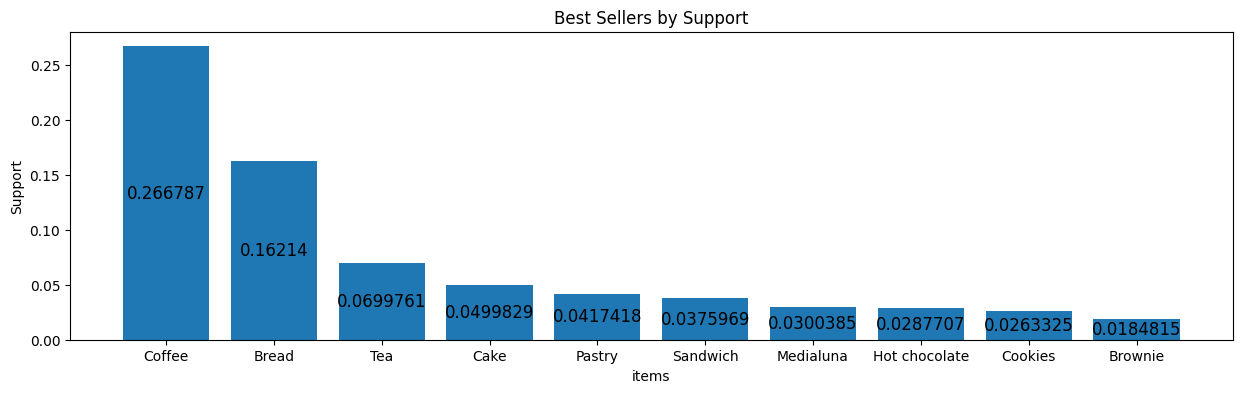

In [ ]:
plt.figure(figsize = (15, 4))

bars = plt.bar(x = support.index[:10], height = support.head(10))
plt.bar_label(bars, fontsize = 12, label_type = 'center')

plt.title('Best Sellers by Support')
plt.ylabel('Support')
plt.xlabel('items')
plt.show()

3. 시간별, 요일별, 월별 거래 빈도를 그래프로 그려보자

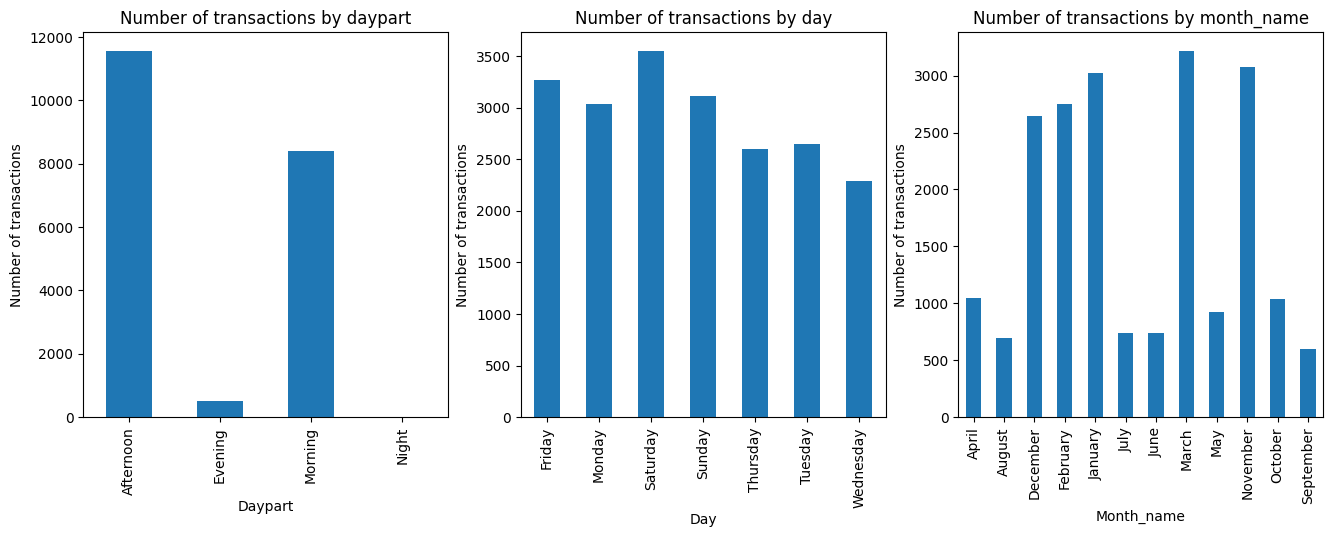

In [ ]:
plt.figure(figsize = (16, 5))

plt.subplot(131)  #plt.subplot(행의 수, 열의 수, 인덱스)
data.groupby('Daypart')['Items'].count().plot(kind = 'bar')
plt.ylabel('Number of transactions')
plt.title('Number of transactions by daypart')

plt.subplot(132)
data.groupby('Day')['Items'].count().plot(kind = 'bar')
plt.ylabel('Number of transactions')
plt.title('Number of transactions by day')

plt.subplot(133)
data.groupby('Month_name')['Items'].count().plot(kind = 'bar')
plt.ylabel('Number of transactions')
plt.title('Number of transactions by month_name')

plt.show()

4. 시간에 따른 item별 판매량을 막대 그래프로 그려보자

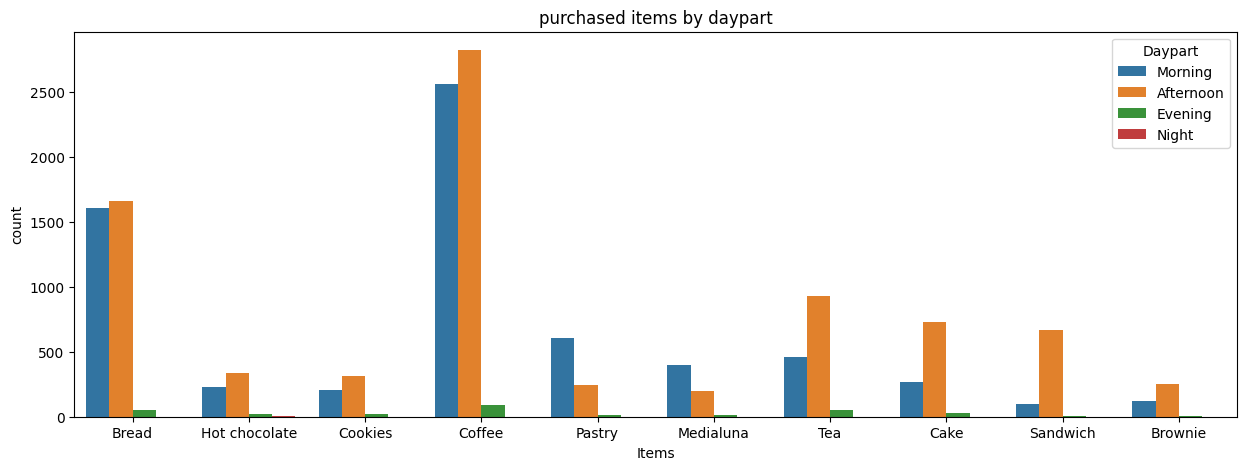

In [ ]:
plt.figure(figsize=(15, 5))

sns.countplot(x = 'Items', data = data_10, hue = 'Daypart')

plt.title("purchased items by daypart")

plt.show()

=> afternoon에서 거래빈도가 가장 많기 때문에, 대부분의 item에서 afternoon의 거래 빈도가 가장 높다. 하지만 pastry와 medialuna는 morning의 거래 빈도가 가장 높다.

morning -> pastry

morning -> medialuna ?

5. 요일에 따른 item별 판매량을 막대 그래프로 그려보자

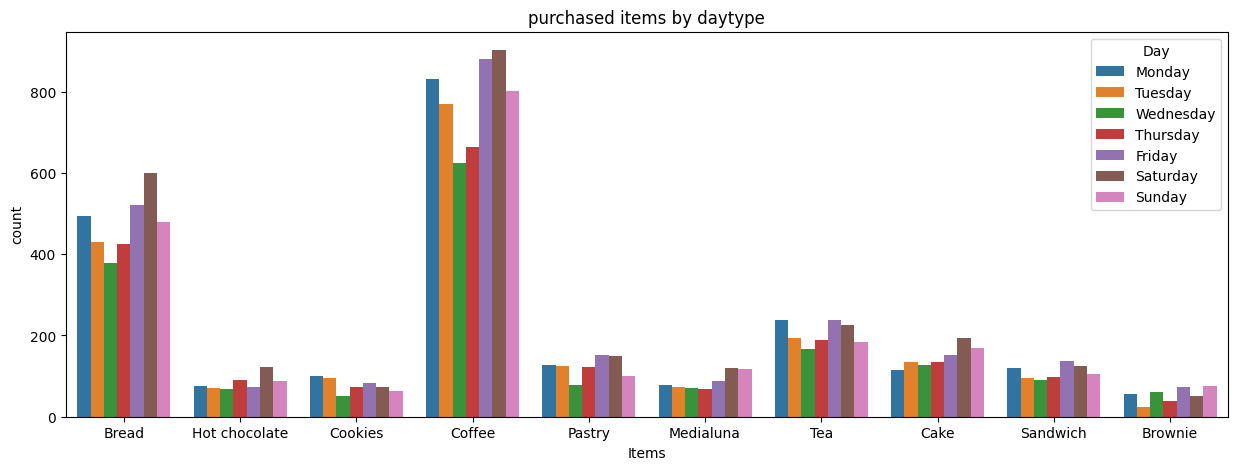

In [ ]:
plt.figure(figsize=(15, 5))

sns.countplot(x = 'Items', data = data_10, hue = 'Day', hue_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

plt.title("purchased items by daytype")

plt.show()

=> 요일별 판매량에서, friday와 saturday의 판매량이 더 높았다. Sunday는 판매량이 가장 높은 요일이 아니었다.

Monday -> Cookies

Monday -> Tea

Sunday -> Brownie ?

6. 월에 따른 item별 판매량을 막대 그래프로 그려보자

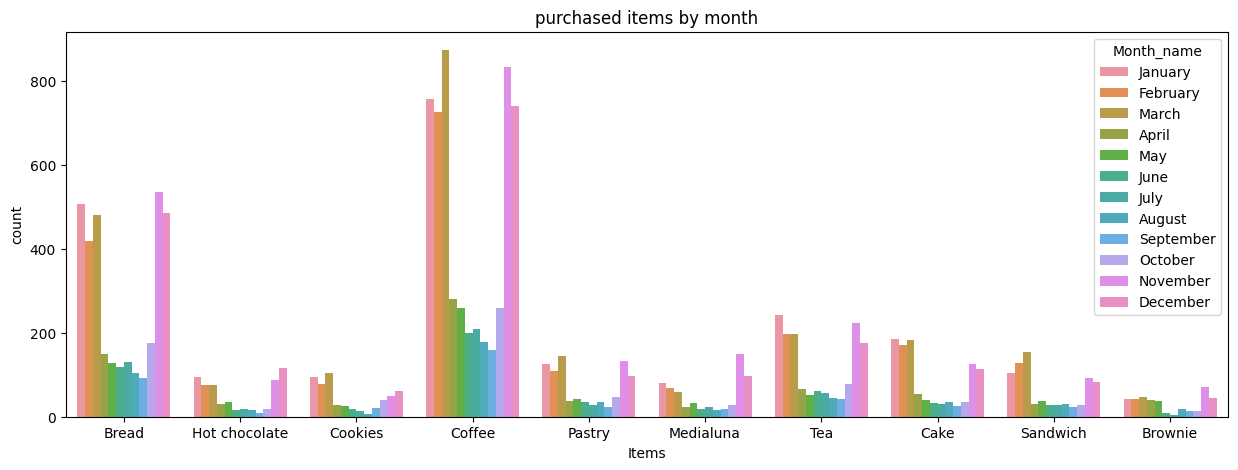

In [ ]:
plt.figure(figsize = (15, 5))

sns.countplot(x = 'Items', data = data_10, hue = 'Month_name', hue_order = ['January','February','March','April','May','June','July','August','September','October','November','December'])

plt.title("purchased items by month")

plt.show()

=> 커피의 구매 빈도가 다른 item에 비해 3월에 구매 빈도가 높다. 정말 3월과 커피 간에 연관성이 존재하는 것일까? 달에 상관없이 그냥 커피가 많이 팔려서 3월이 다른 아이템에 비해 더 높아 보이는 게 아닐까?

March -> coffee ?

December -> Hot chocolate ?

In [ ]:
## 참고자료 : https://www.kaggle.com/code/ekrembayar/apriori-association-rules-grocery-store
## 참고자료 : https://www.kaggle.com/code/esmanuralican/basket-analysis
## 참고자료: https://www.kaggle.com/code/nargeshajmollaali/market-basket-analysis-using-apriori-algorithm
## 참고자료: https://www.kaggle.com/code/bbhatt001/bakery-business-model-association-rules

### 3. Apriori

In [ ]:
data2 = data.drop(['DateTime','DayType'], axis = 1)
data2.head()

,TransactionNo,Items,Daypart,Day,Month_name
0,1,Bread,Morning,Sunday,October
1,2,Scandinavian,Morning,Sunday,October
2,2,Scandinavian,Morning,Sunday,October
3,3,Hot chocolate,Morning,Sunday,October
4,3,Jam,Morning,Sunday,October


In [ ]:
data2[data2['TransactionNo'] == 2].iloc[:,1:].values.tolist()

[['Scandinavian', 'Morning', 'Sunday', 'October'],
 ['Scandinavian', 'Morning', 'Sunday', 'October']]

In [ ]:
all_trans = data2[data2['TransactionNo'] == 2].iloc[:,1:].values.tolist()
np.concatenate(all_trans).tolist()

['Scandinavian',
 'Morning',
 'Sunday',
 'October',
 'Scandinavian',
 'Morning',
 'Sunday',
 'October']

In [ ]:
def apriori_dataset(data):  # Transaction을 기준으로 묶어주자.
  item_set=[]
  for trans in data['TransactionNo'].unique():
    all_trans = data[data['TransactionNo'] == trans].iloc[:,1:].values.tolist()  # transaction별 정리
    item_trans = list(set(np.concatenate(all_trans).tolist()))  # 차원 변경
    item_set.append(item_trans)
  print(item_set[0:2])

  # Apriori에 맞는 데이터 형태로 바꿔주자.
  te=TransactionEncoder()
  te_data=te.fit(item_set).transform(item_set)
  data_x=pd.DataFrame(te_data,columns=te.columns_)
  print(data_x.head())
  return data_x

In [ ]:
apdata = apriori_dataset(data2)

[['Morning', 'Sunday', 'October', 'Bread'], ['Scandinavian', 'Sunday', 'Morning', 'October']]
   Adjustment  Afternoon  Afternoon with the baker  Alfajores  April  \
0       False      False                     False      False  False   
1       False      False                     False      False  False   
2       False      False                     False      False  False   
3       False      False                     False      False  False   
4       False      False                     False      False  False   

   Argentina Night  Art Tray  August  Bacon  Baguette  ...  Tiffin  Toast  \
0            False     False   False  False     False  ...   False  False   
1            False     False   False  False     False  ...   False  False   
2            False     False   False  False     False  ...   False  False   
3            False     False   False  False     False  ...   False  False   
4            False     False   False  False     False  ...   False  False   

   Truffle

In [ ]:
def apriori_table(data_x, minsup, minconf):
  frequent_items = apriori(data_x, use_colnames=True, min_support=minsup, max_len=3)
  rules = association_rules(frequent_items, metric="confidence", min_threshold=minconf)
  return rules.sort_values(by = 'lift', ascending = False)

In [ ]:
aprule = apriori_table(apdata, 0.02, 0.7)
aprule

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
2,(Soup),(Afternoon),0.034443,0.537665,0.032647,0.947853,1.762906,0.014128,8.865952,0.448192
6,"(Sandwich, Coffee)",(Afternoon),0.038246,0.537665,0.033492,0.875691,1.628692,0.012928,3.719228,0.401361
7,"(Coffee, Pastry)",(Morning),0.047544,0.433492,0.033492,0.704444,1.625047,0.012882,1.916757,0.403833
4,(Pastry),(Morning),0.086107,0.433492,0.060433,0.701840,1.619040,0.023107,1.900017,0.418375
1,(Sandwich),(Afternoon),0.071844,0.537665,0.062335,0.867647,1.613731,0.023707,3.493197,0.409757
3,(Toast),(Coffee),0.033597,0.478394,0.023666,0.704403,1.472431,0.007593,1.764582,0.332006
0,(Cake),(Afternoon),0.103856,0.537665,0.073534,0.708037,1.316873,0.017694,1.583537,0.268512
5,"(Cake, Coffee)",(Afternoon),0.054728,0.537665,0.038669,0.706564,1.314134,0.009243,1.575589,0.252882


In [ ]:
def Visual1(aprule):
    fig, ax = plt.subplots(figsize=(10,4))
    #빈 그래프 g1 생성
    g1 = nx.DiGraph()
    N = len(aprule)
    for i in range(N):
        anteced = list(aprule.iloc[i,0])
        conseq = list(aprule.iloc[i,1])
        for ant in anteced:
            for con in conseq:
                g1.add_node(ant)
                g1.add_node(con)
                g1.add_edges_from([(ant,con)])  #ant와 con 간의 연결선 추가
    nx.draw(g1, with_labels = True)
    plt.show()

In [ ]:
def Visual2(aprule):
    #iter(x): 반복 가능한 객체 x를 반복자(iterator)로 변환
    #next(iterator): iterator에서 값을 하나씩 꺼내서 반환
    aprule.antecedents = aprule.antecedents.apply(lambda x: next(iter(x)))
    aprule.consequents = aprule.consequents.apply(lambda x: next(iter(x)))

    fig, ax = plt.subplots(figsize=(10,4))
    #빈 그래프 g2 생성
    g2 = nx.from_pandas_edgelist(aprule, source= 'antecedents', target= 'consequents', create_using = nx.DiGraph())
    nx.draw(g2,with_labels=True)
    plt.show()

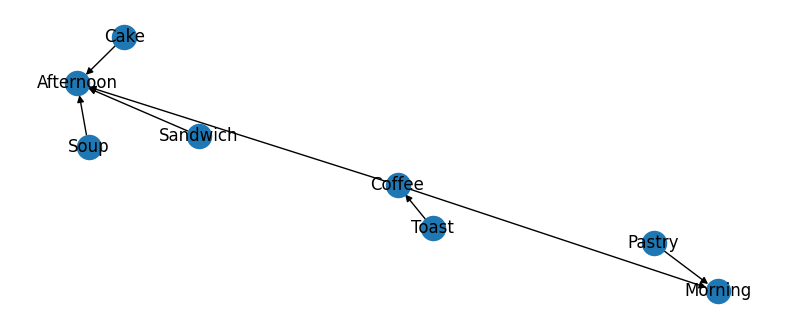

In [ ]:
Visual1(aprule)

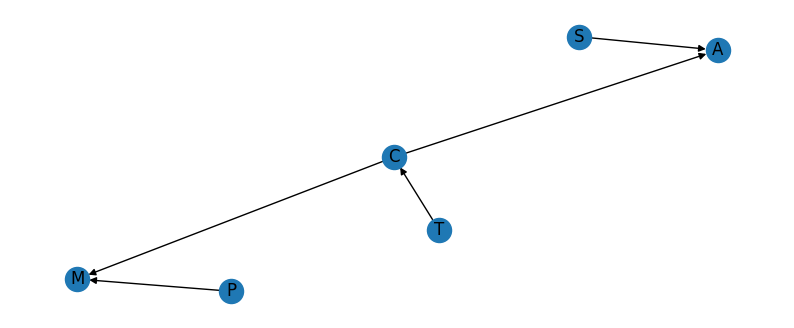

In [ ]:
Visual2(aprule)

In [ ]:
# EDA results
# March-> Cofffee, December -> Hot chocolate, Monday -> Cookie, Monday -> Tea, Sunday -> Brownie
# Morning -> Pastry, Morning -> Medialuna

# Apriori results
# Toast -> Coffee
# Pastry -> Morning
# Cake, Sandwitch, Soup -> Afternoon

# Business Suggestions
# 1. 중심이 되는 노드: Afternoon! 이때 프로모션을 하자.
# 2. Toast - Coffee Cross selling 유도하기
# 3. EDA & 연관분석 대로 Pastry -> Morning이 유의한 것으로 보임.

# 기준을 어떻게 잡는지에 따라 답이 달라질 수 있음.
# 어떻게 판단해야하는가? : 1) EDA와 교차검증! 2) 조건을 바꿔서 연관분석을 돌려보자.

# 지금 이 분석은 EDA와 상당히 다른 결과물을 만들었음.
# 현재 분류기준에 문제가 있음. (ex. 겨울시즌에 판매 집중 반영 X, Afternoon과 관련된 규칙만 추출됨 등....)
# 해결법은.... 과제로 냈습니다!

In [ ]:
class Apriori:
  def __init__(self, data, minsup, minconf):
    self.data = data
    self.minsup = minsup
    self.minconf = minconf
    self.data_x = self.apriori_dataset(data)
    self.rules = self.apriori_table().sort_values(by = 'lift', ascending = False)

  def apriori_dataset(self, data):  # Transaction을 기준으로 묶어주자.
    item_set=[]
    for trans in data['TransactionNo'].unique():
      all_trans = data[data['TransactionNo'] == trans].iloc[:,1:].values.tolist()  #transaction별 정리
      item_trans = list(set(np.concatenate(all_trans).tolist()))  #차원 변경
      item_set.append(item_trans)

  # Apriori에 맞는 데이터 형태로 바꿔주자.
    te=TransactionEncoder()
    te_data=te.fit(item_set).transform(item_set)
    self.data_x=pd.DataFrame(te_data,columns=te.columns_)
    return self.data_x

  def apriori_table(self):
    frequent_items = apriori(self.data_x, use_colnames=True, min_support= self.minsup, max_len = 3)
    self.rules = association_rules(frequent_items, metric="confidence", min_threshold = self.minconf)
    return self.rules

  def Visualize(self):
    aprule.antecedents = self.rules.antecedents.apply(lambda x: next(iter(x)))
    aprule.consequents = self.rules.consequents.apply(lambda x: next(iter(x)))
    fig, ax=plt.subplots(figsize=(10,4))
    g2=nx.from_pandas_edgelist(aprule, source= 'antecedents', target= 'consequents', create_using = nx.DiGraph())
    nx.draw(g2,with_labels=True)
    plt.show()

In [ ]:
ap = Apriori(data2, 0.03, 0.6)
ap.apriori_table()
# 아까보다 EDA 결과와 더 비슷하게 나옴.

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Cake),(Afternoon),0.103856,0.537665,0.073534,0.708037,1.316873,0.017694,1.583537,0.268512
1,(Sandwich),(Afternoon),0.071844,0.537665,0.062335,0.867647,1.613731,0.023707,3.493197,0.409757
2,(Soup),(Afternoon),0.034443,0.537665,0.032647,0.947853,1.762906,0.014128,8.865952,0.448192
3,(Tea),(Afternoon),0.142631,0.537665,0.091284,0.640000,1.190332,0.014596,1.284264,0.186499
4,(Medialuna),(Morning),0.061807,0.433492,0.040148,0.649573,1.498466,0.013355,1.616621,0.354565
5,(Pastry),(Morning),0.086107,0.433492,0.060433,0.701840,1.619040,0.023107,1.900017,0.418375
6,"(Cake, Coffee)",(Afternoon),0.054728,0.537665,0.038669,0.706564,1.314134,0.009243,1.575589,0.252882
7,"(Sandwich, Coffee)",(Afternoon),0.038246,0.537665,0.033492,0.875691,1.628692,0.012928,3.719228,0.401361
8,"(Tea, Coffee)",(Afternoon),0.049868,0.537665,0.030745,0.616525,1.146672,0.003933,1.205647,0.134624
9,"(Coffee, Pastry)",(Morning),0.047544,0.433492,0.033492,0.704444,1.625047,0.012882,1.916757,0.403833


In [ ]:
#Apriori 알고리즘 구현

def itemsets(data):  #transaction별 리스트를 만든다.
  item_sets=[]
  for trans in data['TransactionNo'].unique():
    all_trans = data[data['TransactionNo'] == trans].iloc[:,1:].values.tolist()  #transaction별 정리
    item_trans = list(set(np.concatenate(all_trans).tolist()))  #차원 변경
    item_sets.append(item_trans)
  return item_sets

#Candidate1 생성
#데이터에서 유일한 아이템을 추출하여 후보 아이템 집합을 생성
def createC1(item_sets):
  C1 = []
  for transaction in item_sets:
    for item in transaction:
      if not [item] in C1:
        C1.append([item])
  C1.sort()
  return map(frozenset, C1)  #frozenset: 변경 불가능한 집합

#Candidate2~ 생성
#두 개의 F_(k-1) 아이템 집합을 결합하여 새로운 후보 아이템 집합 Ck를 생성.
def aprioriGen(Fk, k):
    retList = []
    lenFk = len(Fk)
    #두 개의 for문을 통해 Fk 내의 모든 아이템 쌍을 고려 가능
    for i in range(lenFk):
        for j in range(i+1, lenFk):
            #L1과 L2는 Fk[i], Fk[j]에서 각각 마지막 두 아이템을 제외한 나머지 아이템들을 나타낸다.
            #Fk[i]와 Fk[j]의 마지막 아이템을 제외한 나머지 아이템이 동일한 경우에만 두 아이템 집합을 결합 가능
            L1 = list(Fk[i])[:k-2]
            L2 = list(Fk[j])[:k-2]
            L1.sort(); L2.sort()
            if L1 == L2:
                retList.append(Fk[i] | Fk[j])

    return retList

# def supcount : support count 세는 법은 생략

def Apriori2(data, minsupport = 0.03):
    C1 = createC1(data)  #Candidate 1
    itemset = map(set, data)  #item set
    F1, supportvalue = supcount(itemset,C1,minsupport)  #support count
    F = [F1]  #첫 번째 frequent itemset
    k=2
    while (len(F[k-2]) > 0):
        Ck = aprioriGen(F[k-2],k)  #Candidate 2~
        Fk,supK = supcount(itemset,Ck,minsupport) # Support count
        supportvalue.update(supK)
        F.append(Fk) # 특정 지지도 이상의 그룹들만 L에 담는다.즉 가지치기
        k += 1
    return F, supportvalue